In [2]:
import calcLattice
from calcLattice import make_lattice, reset
import draw
from draw import addTripod, make_figure
%matplotlib inline
import matplotlib as mpl
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import itertools
import copy
import pandas as pd
from pymongo import MongoClient
from symmetry_finding import norm_sph
from sph_projection_utils import *
from symmetry_finding import *

In [3]:
from sklearn.cluster import KMeans
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [4]:
db = MongoClient().linus.lattices

In [5]:
df = pd.DataFrame(list(db.find({'sites': {'$exists': True}}).limit(1000)))

In [6]:
keys = range(len(df))

In [7]:
envs = np.round(norm_sph(np.concatenate(df['sites'])), 4)

In [8]:
n_clusters = 100
kmeans_norms = KMeans(n_clusters=n_clusters, random_state=0).fit(envs)

In [9]:
kmeans_colors = kmeans_norms.predict(envs)

In [10]:
unique, counts = np.unique(kmeans_colors, return_counts=True)
print(list(zip(unique, counts)))

[(0, 642), (1, 3838), (2, 7258), (3, 344), (4, 297), (5, 177), (7, 504), (8, 103), (9, 231), (10, 6), (11, 6), (12, 37), (13, 69), (14, 4), (15, 7), (16, 4), (17, 6), (18, 4), (19, 6), (20, 12), (21, 5), (22, 6), (23, 6), (24, 1), (25, 6), (26, 2), (27, 594), (28, 350), (29, 339), (30, 130), (31, 46), (32, 30), (33, 53), (34, 35), (35, 8), (36, 7), (37, 13), (38, 2), (39, 6), (40, 4), (41, 4), (42, 3), (43, 3), (44, 2), (45, 2), (46, 2), (47, 1), (63, 693)]


In [11]:
arr_lens = [len(coord) for coord in df['coords']]
print(arr_lens[:5])

[1, 6, 6, 2, 6]


In [12]:
start = 0
example_dict = {}
for i,lens in enumerate(arr_lens):
    example_dict.update({i: kmeans_colors[start:start+lens]})
    start = start + lens

In [13]:
set_example_dict = {key: set(values) for key, values in example_dict.items()}

In [14]:
# configs_dict = {key: [] for key in set_of_configs}
# for key, values in set_example_dict.items():
#     values = tuple(sorted(tuple(values)))
#     configs_dict[values].append(key)

In [15]:
# configs_keys = list(configs_dict.keys())

In [16]:
# Motif examples
motif_dict = {i: [] for i in range(n_clusters)}
for struct in example_dict:
    for k, motif in enumerate(example_dict[struct]):
        motif_dict[motif].append((struct, k))

In [17]:
def get_local_env(struct, atom, cutoff):
    origin = df['coords'][struct][atom]
    return list(filter(lambda x: np.linalg.norm(np.array(x) - np.array(origin), axis=-1) < cutoff, df['coords'][struct]))

In [18]:
def color_by_numbers(numbers, nmin=0, nmax=None, cmap=None):
    cmap = cm.rainbow if not cmap else cmap
    nmax = max(numbers) if not nmax else nmax
    colors = [cm.rainbow(float((n - nmin))/float(nmax)) for n in numbers]
    return colors

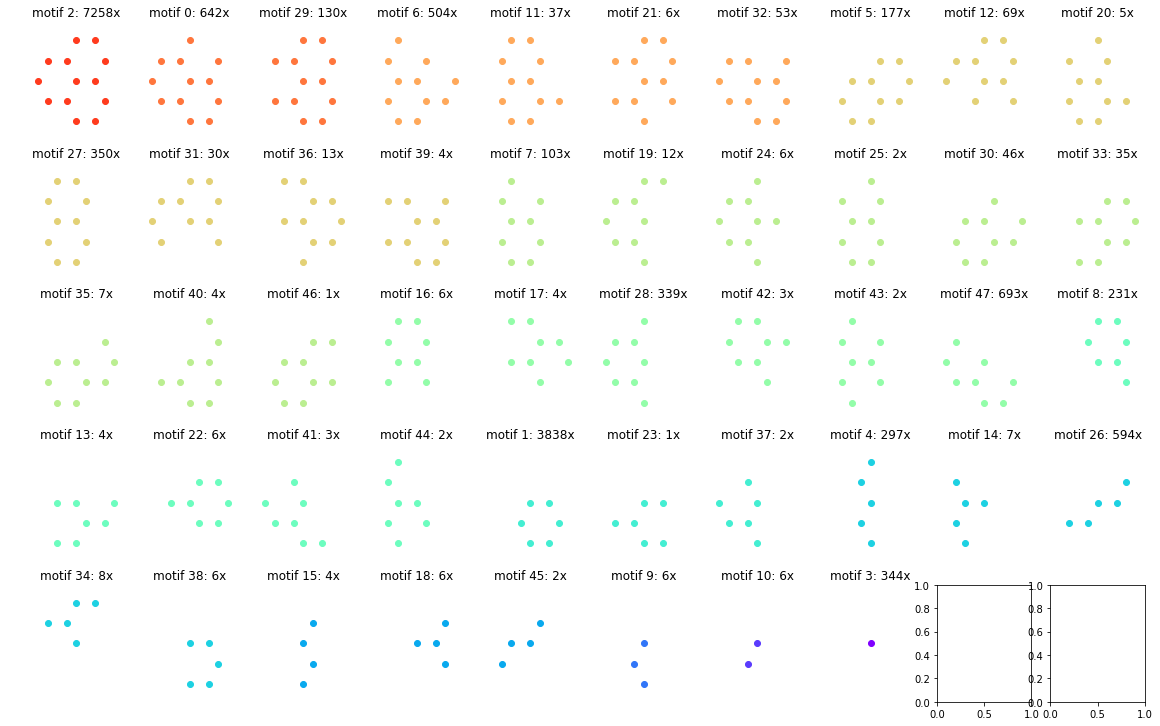

In [19]:
# Plot and sort by number of atoms in motif
coords = []
structs = []
atoms = []
occurances = []
motifs = list(range(n_clusters))
for i in range(n_clusters):
    if len(motif_dict[i]):
        struct, atom = motif_dict[i][0]
        coord = np.array(get_local_env(struct, atom, 5.0))
        adjusted_coord = coord - np.array(df['coords'][struct][atom])
        coords.append(adjusted_coord)
        structs.append(struct)
        atoms.append(atom)
        occurances.append(len(motif_dict[i]))
    else:
        pass

coords, structs, atoms, motifs, occurances = zip(*sorted(zip(coords, structs, atoms, motifs, occurances), key=lambda x: -len(x[0])))
    
fig, axes = plt.subplots(math.ceil(len(motifs) / 10), 10, figsize=(20, 2.5 * math.ceil(len(motifs) / 10)))
axes = axes.flatten()
col_len = [coord.shape[0] for coord in coords]
colors = color_by_numbers(col_len, nmin=min(col_len), nmax=max(col_len))
for i in range(len(motifs)):
    axes[i].scatter(coords[i][:,0],
                    coords[i][:,1],
                    c=[colors[i]])
    axes[i].set_xlim([-5, 5])
    axes[i].set_ylim([-5, 5])
    axes[i].set_axis_off()
    axes[i].set_title("motif {}: ".format(motifs[i]) + str(occurances[i]) + "x")

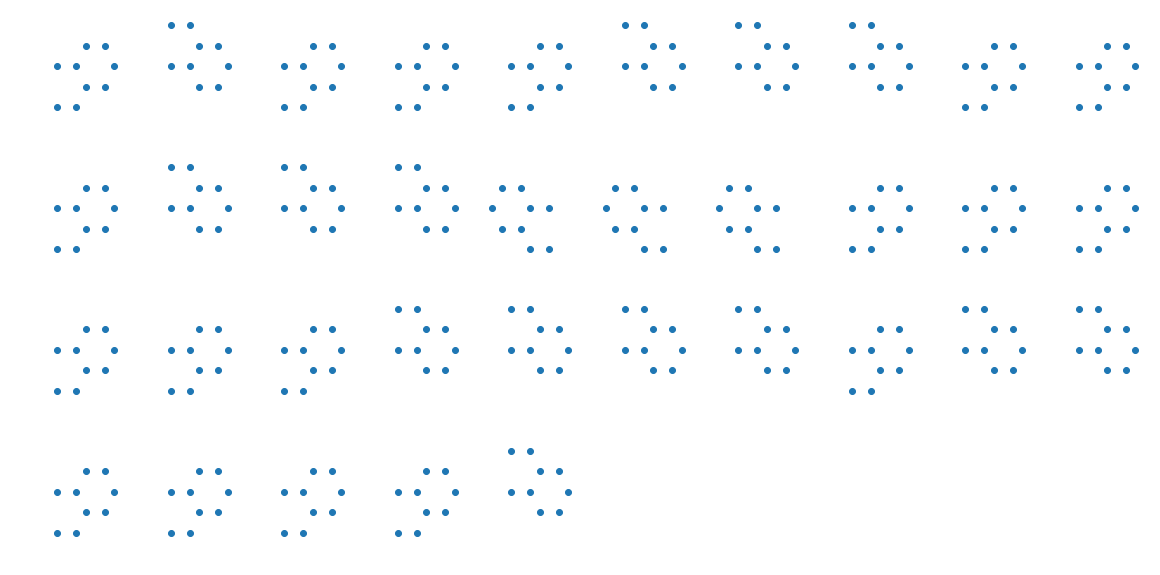

In [20]:
motif = 34
fig, axes = plt.subplots(math.ceil(len(motif_dict[motif]) / 10), 
                         10, 
                         figsize=(20, 2.5 * math.ceil(len(motif_dict[motif]) / 10)))
axes = axes.flatten()
for axis in axes:
    axis.set_axis_off()
for i in range(len(motif_dict[motif])):
    struct, atom = motif_dict[motif][i]
    coord = np.array(get_local_env(struct, atom, 5.0))
    adjusted_coord = coord - np.array(df['coords'][struct][atom])
    axes[i].scatter(*zip(*adjusted_coord))
    axes[i].set_axis_off()
    axes[i].set_xlim([-5, 5])
    axes[i].set_ylim([-5, 5])